In [1]:
# Imports needed for the script
import numpy as np
import pandas as pd
import re
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline


from sklearn import tree
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from IPython.display import Image as PImage
from subprocess import check_call
from PIL import Image, ImageDraw, ImageFont


train = pd.read_csv('data/Titanic/train (1).csv')
test = pd.read_csv('data/Titanic/test.csv')


PassengerId = test['PassengerId']


train.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


In [2]:
#On veut maintenant remplacer toutes les données par des valeurs numériques
full_data =[train,test]

#On commence par remplacer les passagers ayant une cabine par 1 et ceux qui n'en ont pas par 0
train['Has_Cabin'] = train["Cabin"].apply(lambda x: 0 if type(x) == float else 1)
test['Has_Cabin'] = test["Cabin"].apply(lambda x: 0 if type(x) == float else 1)

#On regroupe la taille de la famille en 1 seule colonne en ajoutant Parch à SibSp, puis si le résultat est égal à 1, alors le passager est seul

for dataset in full_data:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] +1
for dataset in full_data:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1
#On supprime des données tous les passagers n'ayant pas embarqué
for dataset in full_data:
    dataset['Embarked'] = dataset['Embarked'].fillna('S')
for dataset in full_data:
    dataset['Fare'] = dataset['Fare'].fillna(train['Fare'].median())
#On supprime des données les passagers dont l'âge n'est pas renseigné
for dataset in full_data:
    age_avg = dataset['Age'].mean()
    age_std = dataset['Age'].std()
    age_null_count = dataset['Age'].isnull().sum()
    age_null_random_list = np.random.randint(age_avg - age_std, age_avg + age_std, size=age_null_count)
    # Next line has been improved to avoid warning
    dataset.loc[np.isnan(dataset['Age']), 'Age'] = age_null_random_list
    dataset['Age'] = dataset['Age'].astype(int)

#On regroupe les titres de chaque passager ensemble. Tout ce qui n'est pas "Monsieur" ou "Madame" sont placés dans un seul groupe "Rare"

    
def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    if title_search:
        return title_search.group(1)
    return ""

for dataset in full_data:
    dataset['Title'] = dataset['Name'].apply(get_title)
    
for dataset in full_data:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')

    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')

    
for dataset in full_data:
    # Mapping Sex
    dataset['Sex'] = dataset['Sex'].map( {'female': 0, 'male': 1} ).astype(int)
    
    # Mapping titles
    title_mapping = {"Mr": 1, "Master": 2, "Mrs": 3, "Miss": 4, "Rare": 5}
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)

    # Mapping Embarked
    dataset['Embarked'] = dataset['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)
    
    # Mapping Fare
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] 						        = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
    dataset.loc[ dataset['Fare'] > 31, 'Fare'] 							        = 3
    dataset['Fare'] = dataset['Fare'].astype(int)
    
    # Mapping Age
    dataset.loc[ dataset['Age'] <= 16, 'Age'] 					       = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[ dataset['Age'] > 64, 'Age'] ;

In [3]:
drop_elements = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp']
train = train.drop(drop_elements, axis = 1)
test  = test.drop(drop_elements, axis = 1)

In [4]:
train.head(3)

,Survived,Pclass,Sex,Age,Parch,Fare,Embarked,Has_Cabin,FamilySize,IsAlone,Title
0,0,3,1,1,0,0,0,0,2,0,1
1,1,1,0,2,0,3,1,1,2,0,3
2,1,3,0,1,0,1,0,0,1,1,4


<AxesSubplot:title={'center':'Relations pour chaque carac'}>

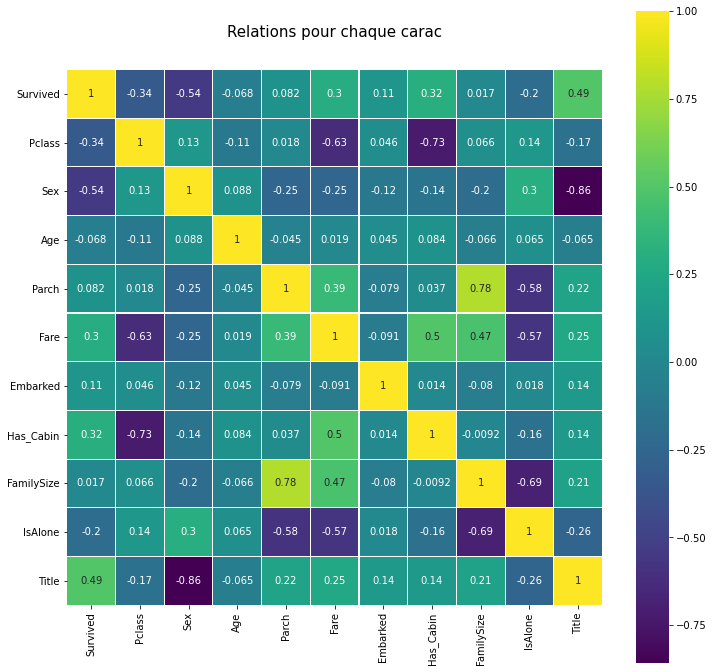

In [5]:
colormap = plt.cm.viridis
plt.figure(figsize=(12,12))
plt.title('Relations pour chaque carac', y=1.05, size=15)
sns.heatmap(train.astype(float).corr(),linewidths=0.1,vmax=1.0, square=True, cmap=colormap, linecolor='white', annot=True)

In [6]:
#Vérifions maintenant le taux de survivants en fonction du genre du passager
train[['Sex','Survived']].groupby(['Sex'], as_index=False).agg(['mean','count','sum'])

Survived           
         mean count  sum
Sex                     
0    0.742038   314  233
1    0.188908   577  109

In [7]:
#Rappelons que 0: Femme, 1:Homme. 74% des femmes survivent pour seulement 18% des hommes

In [8]:
def get_gini_impurity(survived_count, total_count):
    survival_prob = survived_count/total_count
    not_survival_prob = (1 - survival_prob)
    random_observation_survived_prob = survival_prob
    random_observation_not_survived_prob = (1 - random_observation_survived_prob)
    mislabelling_survided_prob = not_survival_prob * random_observation_survived_prob
    mislabelling_not_survided_prob = survival_prob * random_observation_not_survived_prob
    gini_impurity = mislabelling_survided_prob + mislabelling_not_survided_prob
    return gini_impurity

In [9]:
gini_impurity_starting_node = get_gini_impurity(342, 891)
gini_impurity_starting_node

0.47301295786144265

In [10]:

cv = KFold(n_splits=10)           
accuracies = list()
max_attributes = len(list(test))
depth_range = range(1, max_attributes + 1)


for depth in depth_range:
    fold_accuracy = []
    tree_model = tree.DecisionTreeClassifier(max_depth = depth)

    for train_fold, valid_fold in cv.split(train):
        f_train = train.loc[train_fold]
        f_valid = train.loc[valid_fold] 

        model = tree_model.fit(X = f_train.drop(['Survived'], axis=1), 
                               y = f_train["Survived"]) 
        valid_acc = model.score(X = f_valid.drop(['Survived'], axis=1), 
                                y = f_valid["Survived"])
        fold_accuracy.append(valid_acc)

    avg = sum(fold_accuracy)/len(fold_accuracy)
    accuracies.append(avg)
    
 
df = pd.DataFrame({"Max Depth": depth_range, "Average Accuracy": accuracies})
df = df[["Max Depth", "Average Accuracy"]]
print(df.to_string(index=False))

 Max Depth  Average Accuracy
         1          0.782285
         2          0.799189
         3          0.828277
         4          0.819288
         5          0.819301
         6          0.798052
         7          0.805893
         8          0.806991
         9          0.823858
        10          0.820474


In [11]:
y_train = train['Survived']
x_train = train.drop(['Survived'], axis=1).values 
x_test = test.values

#On crée donc l'arbre de décision avec une profondeur max de 3

decision_tree = tree.DecisionTreeClassifier(max_depth = 3)
decision_tree.fit(x_train, y_train)

y_pred = decision_tree.predict(x_test)
submission = pd.DataFrame({
        "PassengerId": PassengerId,
        "Survived": y_pred
    })
submission.to_csv('data/Titanic/gender_submission.csv', index=False)



In [12]:
gender_submission = pd.read_csv('data/Titanic/gender_submission.csv')

gender_submission.head(150)

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1
...,...,...
145,1037,0
146,1038,0
147,1039,0
148,1040,0


In [13]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation

In [14]:
dataset = pd.read_csv('data/Titanic/gender_submission.csv')

In [15]:
dataset.shape

(418, 2)

In [16]:
feature_cols = ['PassengerId']
X = dataset[feature_cols] 
y = dataset.Survived

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

In [18]:
# Create Decision Tree classifer object
clf = DecisionTreeClassifier()

# Train Decision Tree Classifer
clf = clf.fit(X_train,y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test)

In [19]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.47619047619047616


In [20]:
pip install graphviz

Note: you may need to restart the kernel to use updated packages.


In [21]:
pip install pydotplus

Note: you may need to restart the kernel to use updated packages.


In [24]:
from sklearn.tree import export_graphviz
from sklearn.externals.six import StringIO  
import six
import sys
sys.modules['sklearn.externals.six'] = six  
from IPython.display import Image  
import pydotplus

In [27]:
dot_data = StringIO()
export_graphviz(clf, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,feature_names = feature_cols,class_names=['0','1'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('Survived.png')
Image(graph.create_png())

InvocationException: GraphViz's executables not found